In [1]:
import sys
sys.path.append("../src") # Adds higher directory to python modules path.

from early_text_classifier import EarlyTextClassifier
import numpy as np
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, confusion_matrix,\
    classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
etc_kwargs = {'dataset_path': '../dataset/erisk',
              'dataset_name': 'erisk-clean-stemmed',
              'initial_step': 1,
              'step_size': 1}
preprocess_kwargs = {'min_word_length': 2,
                     'max_number_words': 'all'}
cpi_clf = MultinomialNB(alpha=0.5, fit_prior=True)
cpi_kwargs = {'train_dataset_percentage': 0.75,
              'test_dataset_percentage': 0.25,
              'doc_rep': 'term_frec',
              'cpi_clf': cpi_clf}
context_kwargs = {'number_most_common': 100}
dmc_clf = DecisionTreeClassifier(criterion='gini', random_state=0)
dmc_kwargs = {'train_dataset_percentage': 0.75,
              'test_dataset_percentage': 0.25,
              'dmc_clf': dmc_clf}

etc = EarlyTextClassifier(etc_kwargs, preprocess_kwargs, cpi_kwargs,
                          context_kwargs, dmc_kwargs)

Model already trained. Loading it.


In [3]:
etc.print_params_information()

Dataset name: erisk-clean-stemmed
Dataset path: ../dataset/erisk
--------------------------------------------------------------------------------
Pre-process params:
{'max_number_words': 'all', 'min_word_length': 2}
--------------------------------------------------------------------------------
CPI params:
{'cpi_clf': MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True),
 'doc_rep': 'term_frec',
 'initial_step': 1,
 'step_size': 1,
 'test_dataset_percentage': 0.25,
 'train_dataset_percentage': 0.75}
--------------------------------------------------------------------------------
Context Information params:
{'initial_step': 1, 'number_most_common': 100, 'step_size': 1}
--------------------------------------------------------------------------------
DMC params:
{'dmc_clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_sam

In [4]:
Xtrain, ytrain, Xtest, ytest = etc.preprocess_dataset()
etc.fit(Xtrain, ytrain)

Pre-processing dataset
Building dictionary
8331236  total words  83805  unique words
Xtrain.shape: (486, 127325)
ytrain.shape: (486,)
Xtest.shape: (401, 156935)
ytest.shape: (401,)
EarlyTextClassifier model already trained


In [5]:
cpi_perc, cpi_pred, dmc_pred, pred_time, dmc_ytest = etc.predict(Xtest, ytest)

Predicting with the EarlyTextClassifier model


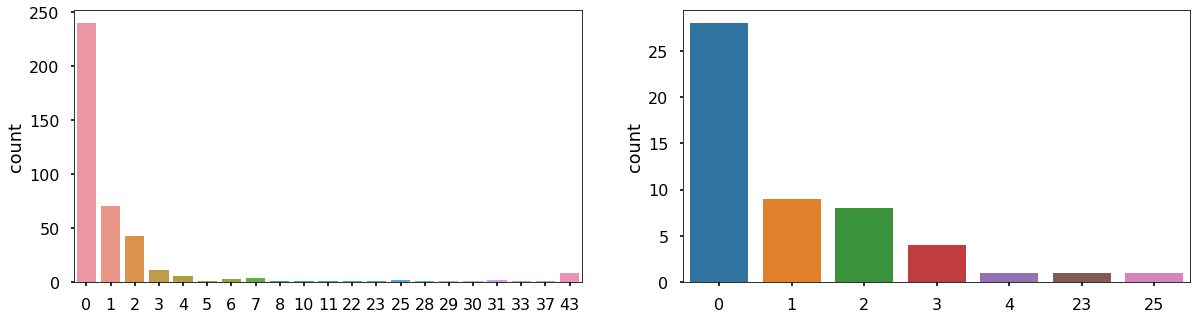

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.countplot(pred_time, ax=ax1);
sns.countplot(pred_time[ytest == 1], ax=ax2);

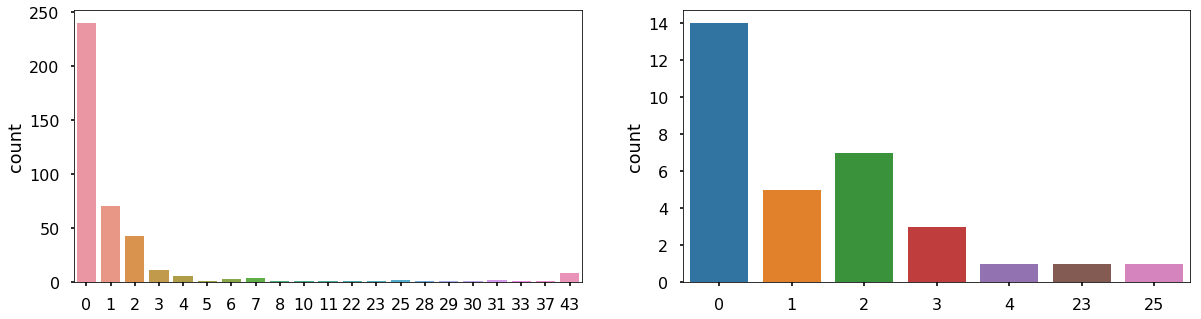

In [7]:
y_pred = []
num_docs = len(ytest)
for i in range(num_docs):
    t = pred_time[i]
    y_pred.append(cpi_pred[t, i])
y_pred = np.array(y_pred)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.countplot(pred_time, ax=ax1);
sns.countplot(pred_time[(ytest == 1) & (y_pred == 1)], ax=ax2);

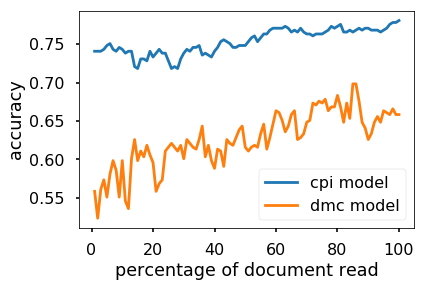

In [8]:
num_steps = len(cpi_perc)
x = cpi_perc
accuracy_cpi = np.sum(cpi_pred == ytest, axis=1) / ytest.size
y_cpi = np.zeros(num_steps)
y_dmc = np.zeros(num_steps)
for idx in range(num_steps):
    y_cpi[idx] = np.sum(cpi_pred[idx] == ytest) / ytest.size
    y_dmc[idx] = np.sum(dmc_pred[idx] == dmc_ytest[idx]) / dmc_ytest[idx].size

plt.plot(x, y_cpi, label='cpi model')
plt.plot(x, y_dmc, label='dmc model')
plt.xlabel('percentage of document read')
plt.ylabel('accuracy')
plt.legend();

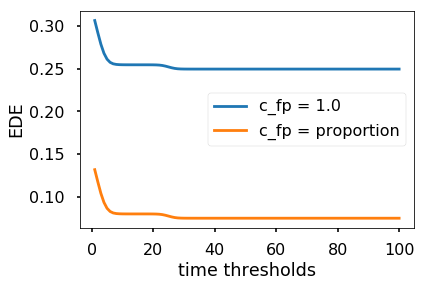

In [9]:
penalization_type = 'Losada-Crestani'
costs_1 = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 1.0}
costs_2 = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 'proportion_positive_cases'}

time_threshold = np.linspace(start=1, stop=100, num=100)
ede_1 = np.zeros_like(time_threshold)
ede_2 = np.zeros_like(time_threshold)
for idx, o in enumerate(time_threshold):
    _, _, _, _, ede_1[idx] = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, o, costs_1, print_ouput=False)
    _, _, _, _, ede_2[idx] = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, o, costs_2, print_ouput=False)

plt.plot(time_threshold, ede_1, label='c_fp = 1.0')
plt.plot(time_threshold, ede_2, label='c_fp = proportion')
plt.xlabel('time thresholds')
plt.ylabel('EDE')
plt.legend();

In [10]:
etc.save_model()

Model already in disk


In [11]:
# Lineal model
lineal_clf = LogisticRegression(C=2, solver='liblinear', n_jobs=1, random_state=0)

lineal_Xtrain = etc.cpi.get_document_representation(Xtrain)
lineal_Xtest = etc.cpi.get_document_representation(Xtest)

lineal_clf.fit(lineal_Xtrain, ytrain)
lineal_y_pred = lineal_clf.predict(lineal_Xtest)

In [12]:
penalization_type = 'Losada-Crestani'
time_threshold = 5
costs = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 'proportion_positive_cases'}
etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type,
          time_threshold, costs);

print('-'*50)
print('-'*50)

# Repeat values so we can use the score method of etc.
lineal_pred_time = 99 * np.ones(ytest.size, dtype=int)
lineal_y_pred_repeted = []
for i in range(cpi_perc.size):
    lineal_y_pred_repeted.append(lineal_y_pred)
lineal_y_pred_repeted = np.array(lineal_y_pred_repeted)

lineal_precision, lineal_recall, lineal_f1, lineal_accuracy, lineal_ede = etc.score(ytest, lineal_y_pred_repeted, cpi_perc, lineal_pred_time, penalization_type, time_threshold, costs, print_ouput=False);
lineal_confusion_matrix = confusion_matrix(ytest, lineal_y_pred)

print(f'{"Score Lineal":^50}')
print('-'*50)
print(f'{"Precision average=macro:":>25} {lineal_precision:.3}')
print(f'{"Recall average=macro:":>25} {lineal_recall:.3}')
print(f'{"F1 Measure average=macro:":>25} {lineal_f1:.3}')
print(f'{"Accuracy:":>25} {lineal_accuracy:.3}')
print(f'{"EDE o=":>21}{time_threshold:<3}: {lineal_ede:.3}')
print('-' * 50)
print(classification_report(ytest, lineal_y_pred, target_names=etc.unique_labels))
print('-' * 50)
print('Confusion matrix:')
pp.pprint(lineal_confusion_matrix)

                    Score ETC                     
--------------------------------------------------
 Precision average=macro: 0.608
    Recall average=macro: 0.693
F1 Measure average=macro: 0.617
                Accuracy: 0.751
               EDE o=5  : 0.0873
--------------------------------------------------
             precision    recall  f1-score   support

   negative       0.93      0.77      0.84       349
   positive       0.29      0.62      0.39        52

avg / total       0.85      0.75      0.78       401

--------------------------------------------------
Confusion matrix:
array([[269,  80],
       [ 20,  32]])
--------------------------------------------------
--------------------------------------------------
                   Score Lineal                   
--------------------------------------------------
 Precision average=macro: 0.747
    Recall average=macro: 0.77
F1 Measure average=macro: 0.758
                Accuracy: 0.885
               EDE o=5  : 0.138
